In [24]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import IPython
import IPython.display
from sklearn.preprocessing import MinMaxScaler

In [25]:
df = pd.read_csv('D:\\Earthquake\\DATASET_STORE\\UPDATE_EARTHQUAKE.csv')
df['time'] = pd.to_datetime(df['time'])
df = df[df['time']>= '2000-01-01 00:00:00']

# Pacific
df = df[(df['latitude'] >= 16) & (df['latitude'] <= 60) & (df['longitude'] >= 114) & (df['longitude'] <= 170) & (df['time'] >= '2000-01-01 00:00:00')]
print(df)

df.describe().transpose()

                      time  latitude  longitude  mag    depth
343928 2000-01-01 19:30:00   23.1120   143.6440  5.2   33.000
343932 2000-01-01 22:47:00   19.0920   145.1820  4.0   33.000
343935 2000-01-02 01:51:00   19.1490   145.5650  4.7  151.600
343936 2000-01-02 02:02:00   47.6050   154.4230  4.2   33.000
343943 2000-01-02 05:24:00   49.6940   150.7090  3.0  350.000
...                    ...       ...        ...  ...      ...
974198 2024-02-20 13:56:27   23.7461   123.2771  4.9   26.711
974199 2024-02-20 14:18:17   23.9553   122.5016  4.5   27.306
974200 2024-02-20 14:57:29   23.6748   123.3215  5.0   19.337
974201 2024-02-20 15:12:29   23.7356   123.2931  4.6   28.087
974205 2024-02-20 16:08:36   23.9752   122.4705  4.4   23.706

[52429 rows x 5 columns]


,count,mean,min,25%,50%,75%,max,std
time,52429,2012-02-05 02:00:08.039787264,2000-01-01 19:30:00,2006-11-17 05:42:00,2011-04-24 09:11:00,2017-07-27 22:16:00,2024-02-20 16:08:36,NaN
latitude,52429.0,35.012886,16.0,26.442,35.871,42.504,59.953,10.313231
longitude,52429.0,141.487044,114.0056,139.007,142.2748,145.6681,169.9896,10.588873
mag,52429.0,4.472562,2.6,4.2,4.4,4.7,9.1,0.445529
depth,52429.0,72.482179,0.0,10.053,35.0,67.24,686.39,104.401141


In [26]:
df.head(3)

,time,latitude,longitude,mag,depth
343928,2000-01-01 19:30:00,23.112,143.644,5.2,33.0
343932,2000-01-01 22:47:00,19.092,145.182,4.0,33.0
343935,2000-01-02 01:51:00,19.149,145.565,4.7,151.6


In [27]:
df['time'] = pd.to_datetime(df['time'])
df.head(3)

,time,latitude,longitude,mag,depth
343928,2000-01-01 19:30:00,23.112,143.644,5.2,33.0
343932,2000-01-01 22:47:00,19.092,145.182,4.0,33.0
343935,2000-01-02 01:51:00,19.149,145.565,4.7,151.6


In [28]:
lat = df['latitude'].values.reshape(-1, 1)
scaler = MinMaxScaler()
lat = scaler.fit_transform(lat)
lat

array([[0.16180921],
       [0.07034787],
       [0.07164471],
       ...,
       [0.17461379],
       [0.17599709],
       [0.18144837]])

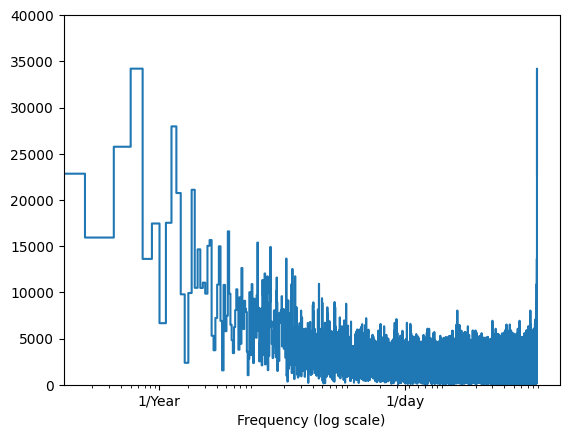

In [29]:
fft = tf.signal.rfft(df['latitude'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['latitude'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

Windows ->
[[[1], [2], [3], [4], [5]]] [6]
[[[2], [3], [4], [5], [6]]] [7]
[[[3], [4], [5], [6], [7]]] [8]

In [30]:
def windows(df, window_size = 5):
    df_np = df
    x = []
    y = []
    for i in range(len(df_np)-window_size):
        row = [[a] for a in df_np[i:i+window_size]]
        x.append(row)
        label = df_np[i+window_size]
        y.append(label)
    return np.array(x), np.array(y)

WINDOWS_SIZE = 30

x, y = windows(lat, WINDOWS_SIZE)

In [31]:
x.shape, y.shape

((52399, 30, 1, 1), (52399, 1))

In [32]:
train_size = 0.7
test_size = 0.1
validate_size = 0.2


x_train, y_train = x[:int(len(x)*train_size)], y[:int(len(y)*train_size)]
x_val, y_val = x[int(len(x)*train_size): int(len(x)*train_size)+ int(len(x)*validate_size)], y[int(len(y)*train_size): int(len(y)*train_size)+ int(len(y)*validate_size)]
x_test, y_test = x[int(len(x)*train_size)+ int(len(x)*validate_size): ], y[int(len(y)*train_size)+ int(len(y)*validate_size): ]

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((36679, 30, 1, 1),
 (36679, 1),
 (10479, 30, 1, 1),
 (10479, 1),
 (5241, 30, 1, 1),
 (5241, 1))

In [33]:
from keras.models import Sequential, load_model
from keras.layers import InputLayer, LSTM, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import MeanSquaredError, MeanAbsoluteError
from keras.activations import *
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError


In [34]:
model = Sequential()
model.add(InputLayer((WINDOWS_SIZE,1)))
model.add(LSTM(64, return_sequences = True))
model.add(LSTM(32, activation=relu))
model.add(Dense(32, activation=relu))
model.add(Dense(1, activation=linear))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [35]:
patience = 2
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')
model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=['accuracy'])


In [36]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=128, callbacks=[early_stopping])
IPython.display.clear_output()
model.save('model_checkpoint_LSTMs.h5')

In [37]:
pred = model.predict(x_test).flatten()
train_result = pd.DataFrame({'Pred': pred, 'Actual': y_test.flatten()})

164/164 [==============================] - 2s 12ms/step


In [38]:
train_result.shape

(5241, 2)

In [39]:
train_result

,Pred,Actual
0,0.335917,0.303051
1,0.329921,0.130062
2,0.309978,0.188051
3,0.299345,0.031056
4,0.268835,0.596753
...,...,...
5236,0.395541,0.176236
5237,0.383153,0.180996
5238,0.372383,0.174614
5239,0.364527,0.175997


In [40]:
# y_pred = np.array([]).astype(np.int64)


# for i in range(12):
#     pred = model.predict(x_test).flatten()
#     d_train = np.concatenate((x_test[-1][1:], np.array([np.int64([pred[-1]])])), axis=0)
#     x_test = np.concatenate((x_test, [d_train]), axis=0)
#     y_pred = np.append(y_pred, np.int64(pred[-1]))
#     print(pred[-1])

# IPython.display.clear_output()

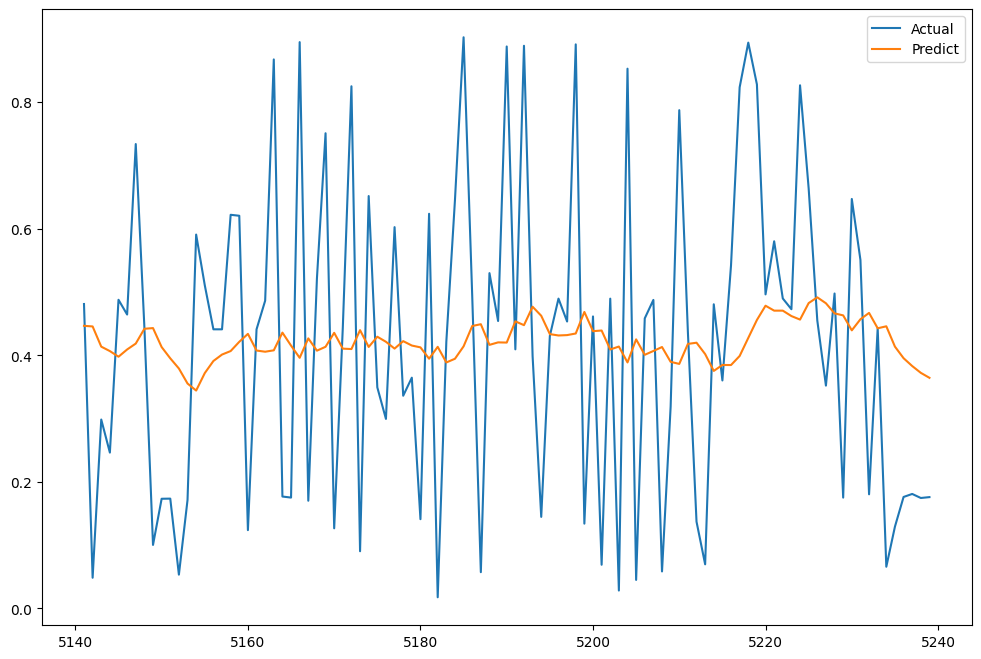

In [41]:
M = -100
N = -1

plt.figure(figsize=(12,8))
plt.plot(train_result['Actual'][M:N], label='Actual')
plt.plot(train_result['Pred'][M:N], label= 'Predict')
# plt.plot(np.arange(len(train_result), len(train_result) + len(y_pred)), y_pred)
plt.legend()
plt.show()